## Research Question:
- What are the effects of smoking, diabetes, BMI, and type of dialysis on the mortality after a kideny transplant. 
### Two datasets are considered: 
- First data set: 
[Long-term outcomes and prognostic factors in kidney transplant recipients in Jakarta, Indonesia: a cohort study](https://zenodo.org/record/6916430#.Y-kH8OzMJb_)
    - In this dataset, there are 754 participants consecutive adult recipients who underwent KT between 2010 and 2020. Rates of 10-year patient, all-cause and death-censored graft survival and their prognostic factors in KT recipients.
    <p>

- Second data set:
[The benefit of kidney transplantation versus remaining on the waitlist depends on patients' baseline comorbidities: a retrospective study](https://zenodo.org/record/4086554#.Y-kIo-zMJb_)

    - 1692 patients were included in the study. Patients without comorbidities had the relative HRD 3-fold higher, immediately after kidney transplantation


### Importing the needed modules

In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt                                   
import seaborn as sns                                               
sns.set(style='whitegrid')
%matplotlib inline


from bokeh.io import output_notebook
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, FactorRange, Whisker,Span
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.transform import jitter
import scipy.special
from scipy.stats import norm

import panel as pn

output_notebook()
pn.extension()





Loading BokehJS ...

## Part 1: Loading the data

In [2]:
import os
cwd = os.getcwd()
print(cwd)

/Volumes/ROYA/Projects/Kidney_transplant/kidney_transplant_waiting_list


In [7]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)
    
df_patients_indonesia = pd.read_excel(config["indonesia"]) 
print("The number of indonesia patients are :",len(df_patients_indonesia))

df_patients_universal = pd.read_excel(config["universal"]) 
print("The number of universal patients are :",len(df_patients_universal))



The number of indonesia patients are : 754
The number of universal patients are : 1692


In [8]:
df_patients_indonesia.head()

,ID,PS,PT_PS,AC_Graft,PT_AC,DC_Graft,PT_DC,Age60,Overweight,Duration24,...,Diabetes,Rejection,Cardiovascular,Infections,Delayed_Graft,Crossmatch,Donor_age40,Related,Donor_overweight,Donor_GFR100
0,170,0,67,0,67,0,67,2,NaN,NaN,...,2,2,2.0,2.0,2,NaN,NaN,NaN,NaN,NaN
1,315,0,69,0,69,0,69,2,2.0,2.0,...,1,2,1.0,2.0,2,NaN,2.0,0.0,NaN,NaN
2,442,0,55,0,55,0,55,2,1.0,1.0,...,1,2,2.0,2.0,2,NaN,2.0,1.0,2.0,2.0
3,385,0,62,0,62,0,62,2,2.0,1.0,...,1,2,2.0,2.0,2,4.0,1.0,1.0,2.0,2.0
4,16,0,119,0,119,0,119,2,2.0,1.0,...,1,2,1.0,2.0,2,5.0,2.0,1.0,1.0,2.0


In [9]:
df_patients_universal.head()

,Number,Age,BMI,Education,Smoking,CHF,DM,CAD,PVD,CVD,...,Vitamin D,PTH,KTx,donor type,death,Death on WL,Death aflter KTx,Follow-up WL,Follow-up KTx,General Follow-up
0,1,1,24.05,1.0,2.0,0.0,1.0,0.0,0.0,0.0,...,13.0,295,0,NaN,1,1,NaN,1332.000000,NaN,1332.000000
1,2,2,19.56,NaN,1.0,0.0,1.0,0.0,0.0,0.0,...,35.0,328,0,NaN,0,0,NaN,1082.000000,NaN,1082.000000
2,3,3,29.00,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,17.0,309,0,NaN,0,0,NaN,2823.000000,NaN,2823.000000
3,4,1,16.74,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,32.8,108,0,NaN,0,0,NaN,2963.000000,NaN,2963.000000
4,5,3,22.32,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,34.8,330,0,NaN,1,1,NaN,238.545833,NaN,238.545833


## Part 2: Prepare and Inspect the data 


In [10]:
# Renaming the columns that might be needed for the first data set
df_patients_indonesia = df_patients_indonesia[[
    "PS",                  # (patient survival); 0 sensor, 1 event
    "PT_PS",               # (patient time, patient survival); in months
    "Age60",               # (age classification); 1> 60 yo, 2 <60 yo 
    "Overweight",          # 1 yes, 2 no 
    "Duration24",          # (dialysis duration before transplant classification); 1 >24 months, 2 <24 months 
    "Dialysis_type",       #  0 hemodialysis, 1 CAPD, 2 HD+CAPD, 3 preemptive transplant
    "Smoking",             # 1 yes, 2 no 
    "Diabetes",            # (type 2 diabetes mellitus); 1 yes 2 no 
    "Rejection",           # 1 yes 2 no 
]]

df_patients_indonesia.rename(columns={
    "PS":"death",
    "PT_PS":"death_time",
    "Age60":"age",
    "Overweight":"overweight",
    "Duration24":"dialysis_time",
    "Dialysis_type":"dialysis_type",
    "Smoking":"smoking",
    "Diabetes":"diabetes",
    "Rejection":"transplant_rejection",    
}, inplace=True)

df_patients_indonesia.head(20)

,death,death_time,age,overweight,dialysis_time,dialysis_type,smoking,diabetes,transplant_rejection
0,0,67,2,NaN,NaN,0.0,2,2,2
1,0,69,2,2.0,2.0,0.0,1,1,2
2,0,55,2,1.0,1.0,0.0,1,1,2
3,0,62,2,2.0,1.0,0.0,1,1,2
4,0,119,2,2.0,1.0,0.0,1,1,2
5,0,26,2,2.0,1.0,0.0,1,1,1
6,0,8,2,2.0,1.0,0.0,1,1,2
7,0,13,2,2.0,1.0,0.0,1,1,2
8,0,25,1,NaN,2.0,0.0,1,1,2
9,0,75,2,NaN,2.0,0.0,1,1,2


In [11]:
# droping the features that are NaN
df_patients_indonesia = df_patients_indonesia.dropna()

In [12]:
# checking the data types before data processing
print('Data Types are :',df_patients_universal.dtypes)
# changing the data types that we need to persue the answer of the question
df_patients_indonesia = df_patients_indonesia.astype({
    "overweight":"int",
    "dialysis_time":"int",
    "dialysis_type":"int",
})

Data Types are : Number                 int64
Age                    int64
BMI                  float64
Education            float64
Smoking              float64
CHF                  float64
DM                   float64
CAD                  float64
PVD                  float64
CVD                  float64
Hypertension         float64
HCV/HBV                int64
Type of dialysis       int64
NKD                  float64
Time on dialysis     float64
Time on WL           float64
Panel                float64
P                    float64
Albumin              float64
Vitamin D            float64
PTH                   object
KTx                    int64
donor type           float64
death                  int64
Death on WL            int64
Death aflter KTx     float64
Follow-up WL         float64
Follow-up KTx        float64
General Follow-up    float64
dtype: object


In [13]:
# getting percentage of missing values per feature
df_patients_indonesia.isna().sum()/len(df_patients_indonesia)*100


death                   0.0
death_time              0.0
age                     0.0
overweight              0.0
dialysis_time           0.0
dialysis_type           0.0
smoking                 0.0
diabetes                0.0
transplant_rejection    0.0
dtype: float64

#### Data formatting: To make the data consistant and easy to undrestand we should care about data formatting. The values of common columns were different in the two data sets, so we had to make them in the same format.

In [14]:
# age is classified to 1:under 60 and 2: above 60
df_patients_indonesia["age"] = df_patients_indonesia["age"].apply(lambda x: 1 if x==2 else 2)
# diabetes is classified to 1: diabetic and 0: non-diabetic
df_patients_indonesia["diabetes"] = df_patients_indonesia["diabetes"].apply(lambda x: 0 if x==2 else x)
# smoking is classified as 1: smoker and 0: non smoker
df_patients_indonesia["smoking"] = df_patients_indonesia["smoking"].apply(lambda x: 0 if x==2 else x)
# overweight calssification is 1: obese and 0: not obese
df_patients_indonesia["overweight"] = df_patients_indonesia["overweight"].apply(lambda x: 0 if x==2 else x)
# dialysis_time is classified to 1: more than 24 months and 0: less than 24 months
df_patients_indonesia["dialysis_time"] = df_patients_indonesia["dialysis_time"].apply(lambda x: 1 if x==2 else 2)
# dialysis_type is classified into 3 groups:0 CAPD, 1 hemodialysis , 2 preemptive transplant
df_patients_indonesia["dialysis_type"] = df_patients_indonesia["dialysis_type"].apply(
    lambda x: 1 if x==0 else (0 if x==1 or x==2 else 2))

df_patients_indonesia.head(20)

,death,death_time,age,overweight,dialysis_time,dialysis_type,smoking,diabetes,transplant_rejection
1,0,69,1,0,1,1,1,1,2
2,0,55,1,1,2,1,1,1,2
3,0,62,1,0,2,1,1,1,2
4,0,119,1,0,2,1,1,1,2
5,0,26,1,0,2,1,1,1,1
6,0,8,1,0,2,1,1,1,2
7,0,13,1,0,2,1,1,1,2
10,0,4,2,1,1,1,1,1,2
11,0,55,2,1,1,1,1,1,2
12,0,54,2,1,1,1,1,1,2


In [15]:
# Renaming the columns that might be needed for the second data set
df_patients_universal = df_patients_universal[[
    "Age",                 # 3 --> > 60 years old
    "BMI",                 # Continuous variable
    "Smoking",             # 1 yes, 2 no
    "DM",                  # Diabetes Mellitus 0 no, 1 yes
    "Hypertension",        # Hypertension 0 no, 1 yes
    "Type of dialysis",    # Type of dialysis  0 Conservative Treatment, 1	Hemodiaylisis ,2 Peritoneal dialysis
    "Time on dialysis",    # Time on dialysis, days
    "Time on WL",          # Time on waitlist, days
    "Panel",               # Calculate panel-reactive antibody 0 – 30% , 1 - >30%
    "KTx",                 # Kidney transplantation 0 no, 1 yes
    "Death aflter KTx",    # Death after kidney transplantation 0 no, 1 yes   
    "Follow-up KTx",       # Follow-up Death after kidney transplantation, days 
]]

df_patients_universal.rename(columns={
    "Age": "age",                 
    "BMI": "overweight",                
    "Smoking": "smoking",            
    "DM": "diabetes",                 
    "Hypertension": "hypertension",        
    "Type of dialysis": "dialysis_type",    
    "Time on dialysis": "dialysis_time",  
    "Time on WL": "waitlist_time",      
    "Panel": "panel",               
    "KTx": "transplantation",                 
    "Death aflter KTx": "death",
    "Follow-up KTx": "death_time",     
}, inplace=True)

# we consider only the death after tarnsplantation, not all the pationats that are in waiting list
df_patients_universal = df_patients_universal[df_patients_universal["transplantation"] == 1]


In [16]:
# getting percentage of missing values per feature
print(df_patients_universal.isna().sum()/len(df_patients_universal)*100)
df_patients_universal["panel"] = np.where(df_patients_universal["panel"].isna(), 0 , df_patients_universal["panel"])
df_patients_universal = df_patients_universal.dropna()


age                 0.000000
overweight         11.197917
smoking             3.125000
diabetes            0.000000
hypertension        0.000000
dialysis_type       0.000000
dialysis_time       2.864583
waitlist_time       0.000000
panel               1.302083
transplantation     0.000000
death               0.000000
death_time          0.000000
dtype: float64


In [17]:
print(df_patients_universal.dtypes)
df_patients_universal = df_patients_universal.astype({
    "smoking":"int",
    "diabetes":"int",
    "hypertension":"int",
    "panel":"int",
    "death":"int"
    })


age                  int64
overweight         float64
smoking            float64
diabetes           float64
hypertension       float64
dialysis_type        int64
dialysis_time      float64
waitlist_time      float64
panel              float64
transplantation      int64
death              float64
death_time         float64
dtype: object


In [18]:
# data formating and reshaping of second data set
df_patients_universal["age"] = df_patients_universal["age"].apply(lambda x: 1 if x==1 or x==2 else 2)
df_patients_universal["smoking"] = df_patients_universal["smoking"].apply(lambda x: 0 if x==2 else x)
# BMI is classified into two categories: 1. overweight 0. fit
df_patients_universal["overweight"] = df_patients_universal["overweight"].apply(lambda x: 1 if x>=23 else 0)
df_patients_universal["dialysis_time"] = df_patients_universal["dialysis_time"].apply(lambda x: 1 if x<=24 * 30 else 2)
# changing the contents of columns into months
df_patients_universal["waitlist_time"] = df_patients_universal["waitlist_time"].apply(lambda x:  int(x / 30) if x > 30 else 1)
df_patients_universal["death_time"] = df_patients_universal["death_time"].apply(lambda x:  int(x / 30) if x > 30 else 1)

# df_patients_universal.head(20)

In [19]:
# droping the columns that was not useful to answer the research question 
df_patients1 = df_patients_indonesia.drop(columns={"transplant_rejection"})
df_patients2 = df_patients_universal.drop(columns={"hypertension", "panel", "waitlist_time", "transplantation"})
# concating of two data sets and create one dataset.
df_patients = pd.concat([df_patients1, df_patients2], ignore_index=True)
print('Number of patients are : ', len(df_patients))



Number of patients are :  1333


In [20]:
#checking 15 random samples to have an idea of the data
df_patients.sample(15)


,death,death_time,age,overweight,dialysis_time,dialysis_type,smoking,diabetes
445,0,20,1,1,1,1,0,0
577,1,7,1,0,1,1,0,0
673,0,35,1,0,1,0,0,0
580,0,56,1,0,1,1,0,0
502,0,120,1,0,1,1,0,0
448,0,95,2,1,1,1,0,0
1286,0,7,1,0,1,1,0,0
706,1,4,1,0,2,1,0,0
1300,0,24,1,1,2,2,1,1
551,0,18,1,0,1,1,0,0


In [21]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   death          1333 non-null   int64
 1   death_time     1333 non-null   int64
 2   age            1333 non-null   int64
 3   overweight     1333 non-null   int64
 4   dialysis_time  1333 non-null   int64
 5   dialysis_type  1333 non-null   int64
 6   smoking        1333 non-null   int64
 7   diabetes       1333 non-null   int64
dtypes: int64(8)
memory usage: 83.4 KB


## Part 3: EXPLORATORY DATA ANALYSIS 


In [22]:
# variables for plots to make them uniform
colors      = ['skyblue', 'green']
line_color  = 'black'
plot_width  = 600
plot_height = 400

def show_plot(
    data, title, 
    max_y=60, 
    x_label="", 
    y_label="", 
    palette=colors, 
    factors=["dead", "live"]):
    """
    This function is defined to be used by other plots that need Bokeh library

    Args:
        data (Dataframe): datafarme used to plot
        title (Str): description of plot
        x_label (str, optional): description of x axis
        y_label (str, optional): description of y axis
        palette (Dict): colors used in plot
        factors (list): description of categories, 
            Defaults to ["dehydration", "control"].

    Returns:
        p: plot
    
    Author(s):
        Roya Gharehbeiklou
    """
    index_cmap = factor_cmap(
        'x',
        palette=palette, 
        factors=factors, 
        start=1, 
        end=2)
    x = list(data.index.values)
    data_map = {
        'x': x,
        'counts': data.tolist()
        }
    
    source = ColumnDataSource(data=data_map)
    p = figure(
        x_range=FactorRange(*x),
        y_range=(0, max_y), 
        width=plot_width,
        height=plot_height, 
        title=title, 
        x_axis_label=x_label, 
        y_axis_label=y_label)

    p.vbar(
        x='x',
        top='counts', 
        source=source,
        fill_color=index_cmap, 
        line_color=line_color)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    return p

def plot_standard_error(plot, data):
    """
    This function is used to show error plot

    Args:
        plot (plot): plot
        data (dataframe): data which is intended to be drawn

    Returns:
        plot: plot
    
    Author(s):
        Roya Gharehbeiklou
    """
    x = list(data.index.values)
    data_map = {
        'x': x,
        'upper': data["upper"].tolist(),
        'lower': data["lower"].tolist()

        }
    source = ColumnDataSource(data=data_map)

    w = Whisker(source=source, base="x", upper="upper", lower="lower", 
            line_color='black', level="overlay")
    w.upper_head.line_color = 'black'
    w.lower_head.line_color = 'black'
    w.upper_head.size = w.lower_head.size = 20
    plot.add_layout(w)
    return plot


In [23]:
def make_data_ready_to_plot():
    """
    To plot the data, meaning of data is important,
    to show it on the figures, this function is necessary 

    Returns:
        df_patients_plot (dataframe) : dataframe 
    Author(s):
        Roya Gharehbeiklou
    """
    df_patients_plot = df_patients.copy()
    df_patients_plot["death"] = df_patients_plot["death"].map({1: "dead", 0: "living"})

    df_patients_plot["age"] = df_patients_plot["age"].map({1: "over 60", 2: "under 60"})
    df_patients_plot["overweight"] = df_patients_plot["overweight"].map({0: "fit", 1: "Obese"})
    df_patients_plot["smoking"] = df_patients_plot["smoking"].map({0: "no", 1: "yes"})
    df_patients_plot["diabetes"] = df_patients_plot["diabetes"].map({0: "non-diabetic", 1: "diabetic"})
    df_patients_plot["dialysis_time"] = df_patients_plot["dialysis_time"].map({1: "less than 24 months", 2: "more than 24 months"})

    return df_patients_plot
    # print(df_patients_plot.head())
    
def plot_data_by_column_name(column="smoking"):
    """
    prepare and draw the plot

    Args:
        column (str, optional): column name. Defaults to "smoking".

    Returns:
        plot: plot
    """
    df_patients_plot = make_data_ready_to_plot()
    data = df_patients_plot.groupby(["death", column])["death_time"].mean()
    # print(list(data.index.values))
    # plot_data = show_plot(data,"hello")
    # show(plot_data)
    return show_plot(
        data, 
        f"Average of death time based on  {column} parameter", 
        80, 
        f"{column}",
        "average time (months)",
        factors=df_patients_plot[column].unique().tolist())
    



### Visualzing data

#### Bar plot of average time of death according to age, overweight, smoking, diabetes 

In [35]:
import panel as pn

# Define the column names for which you want to create plots
column_names_for_plot = ["age", "overweight", "smoking", "diabetes"]

# Create a dropdown menu for selecting the column name
dropdown = pn.widgets.Select(name='Select Attribute:', options=column_names_for_plot)

# Use the Panel library's interact function to create an interactive plot
# The plot_data_by_column_name function will be called with the selected column name
interactive_plot = pn.interact(plot_data_by_column_name, column=dropdown)

# Display the interactive plot
interactive_plot


BokehModel(combine_events=True, render_bundle={'docs_json': {'f40e4d31-ee87-46da-9762-9d4fe39c0a3c': {'version…

In [36]:
df_patients_plot = make_data_ready_to_plot()
print('-'*30)
data = df_patients_plot.groupby(["death", "age"])["death_time"].mean()
print(data.reset_index())
print('-'*30)
data = df_patients_plot.groupby(["death", "overweight"])["death_time"].mean()
print(data.reset_index())
print('-'*30)
data = df_patients_plot.groupby(["death", "smoking"])["death_time"].mean()
print(data.reset_index())
print('-'*30)
data = df_patients_plot.groupby(["death", "diabetes"])["death_time"].mean()
print(data.reset_index())



------------------------------
    death       age  death_time
0    dead   over 60   21.960000
1    dead  under 60   20.846154
2  living   over 60   46.514226
3  living  under 60   47.083333
------------------------------
    death overweight  death_time
0    dead      Obese   18.342593
1    dead        fit   24.491667
2  living      Obese   43.534653
3  living        fit   49.170000
------------------------------
    death smoking  death_time
0    dead      no   21.986577
1    dead     yes   20.810127
2  living      no   48.247776
3  living     yes   42.503145
------------------------------
    death      diabetes  death_time
0    dead      diabetic   23.490566
1    dead  non-diabetic   19.918033
2  living      diabetic   52.080229
3  living  non-diabetic   44.062169


<span style="color:pink">Explanation: </span> According to this plot, there is no significant difference between the death time of those who were smoker, diabetic and their age was over or under 60. However obesity has influenced death time. In other terms, data of fit people with 24.49 months and obese people with 18.34 month illustrate that overweight is an important parameter.


---

#### Bar plot of average time of death according to age, overweight, smoking, diabetes 

In [37]:
import ipywidgets as widgets
from IPython.display import display

# Define the attributes for which you want to create box plots
attributes = ["smoking", "age", "diabetes", "overweight"]

# Create a dropdown menu for selecting the attribute
dropdown = widgets.Dropdown(options=attributes, description='Attribute:')

# Define a function for creating the box plot
def create_boxplot(attribute):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=df_patients_plot, x=attribute, y="death_time", hue=attribute, ax=ax, palette='viridis', legend=False)
    ax.set_title('Box plot over patients attributes', fontsize=16)
    ax.set_xlabel(attribute, fontsize=14)
    ax.set_ylabel('Death Time', fontsize=14)
    plt.grid(True)
    plt.show()

# Create an interactive plot
widgets.interact(create_boxplot, attribute=dropdown)



interactive(children=(Dropdown(description='Attribute:', options=('smoking', 'age', 'diabetes', 'overweight'),…

<function __main__.create_boxplot(attribute)>

<span style="color:pink">Explanation: </span> According to box plots, it can be seen that there is not much outlier data and it increased the probability of normal distribution over death time based on these parameters. 

---

#### Pi chart of dialysis time of according to dead or living patients

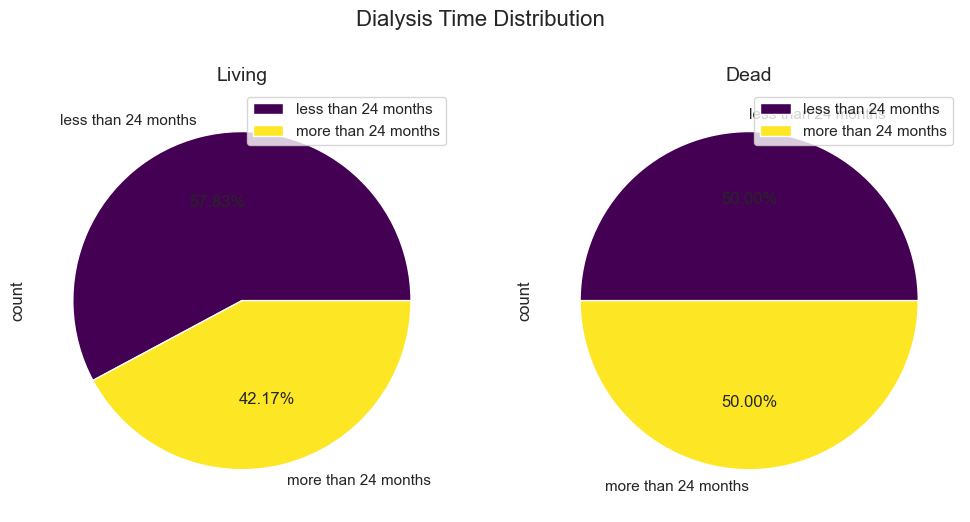

In [39]:
df_patients_plot = make_data_ready_to_plot()

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set the title for the figure
fig.suptitle('Dialysis Time Distribution', fontsize=16)

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(df_patients_plot["dialysis_time"].unique())))

# Create a pie chart for the "living" patients
df_patients_plot[df_patients_plot["death"] == "living"]["dialysis_time"].value_counts().plot(kind='pie', autopct='%1.2f%%', ax=ax1, colors=colors)
ax1.title.set_text("Living")
ax1.title.set_fontsize(14)
ax1.legend(loc="upper right")

# Create a pie chart for the "dead" patients
df_patients_plot[df_patients_plot["death"] == "dead"]["dialysis_time"].value_counts().plot(kind='pie', autopct='%1.2f%%', ax=ax2, colors=colors)
ax2.title.set_text("Dead")
ax2.title.set_fontsize(14)
ax2.legend(loc="upper right")

# Show the plot
plt.show()




<span style="color:pink">Explanation: </span> According to pie plots, 57.83% of living people's dialysis time was less than 24 months and it seems that it's better to do the transplant sooner. However for dead people this period proportions are the same. 


---

#### Heat map of correlation for dead patients 

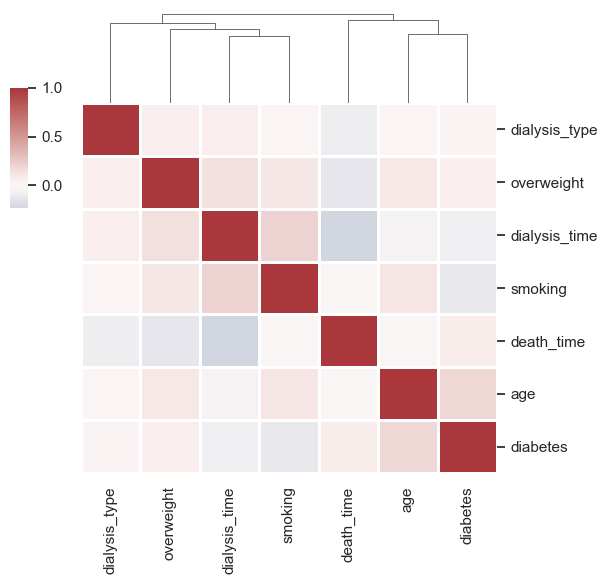

In [44]:
# check for correlation of dead people and all parameters
plot_df = df_patients[df_patients["death"] == 1].copy()
plot_df.drop(columns=["death"], inplace=True)
g = sns.clustermap(plot_df.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-.01, .64, .03, .2),
                   linewidths=.75, figsize=(6, 6))

g.ax_row_dendrogram.remove()


<span style="color:pink">Explanation: </span> According to this plot, for dead people there are not any specific correlation between all variables.


---

#### Heat map of correlation for living patients 

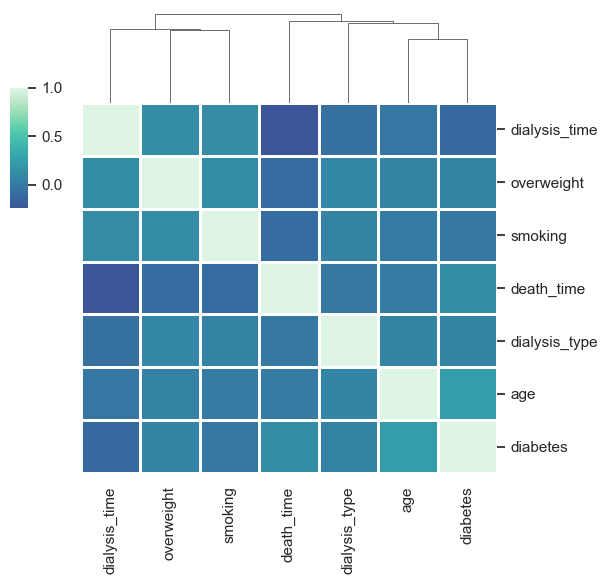

In [43]:
# check for correlation of live people and all parameters
plot_df = df_patients[df_patients["death"] == 0].copy()
plot_df.drop(columns=["death"], inplace=True)
g = sns.clustermap(plot_df.corr(), center=0, cmap="mako",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-.01, .64, .03, .2),
                   linewidths=.75, figsize=(6, 6))

g.ax_row_dendrogram.remove()

<span style="color:pink">Explanation: </span> According to this plot, for living people there are not any specific correlation between all variables.


---

#### Histogram of data over all columns

In [48]:
# Define the function to create the plot
def make_plot(title, hist, edges):
    """
    This function plots the histogram based on numpy array

    Args:
        title (str): title
        hist (array): The values of the histogram.
        edges (array): the bin edges ``(length(hist)+1)``

    Returns:
        p: a figure object
    """
    p = figure(title=title, tools='', background_fill_color="#fafafa", width=300, height=300)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=Viridis256, line_color="white", alpha=0.5)
    p.y_range.start = 0
    p.xaxis.axis_label = 'Value'
    p.yaxis.axis_label = 'Count'
    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"
    p.title.text_font_size = '16pt'
    p.grid.grid_line_color="white"
    return p

# Distribution
g = []
for i in range(len(df_patients.columns)):
    hist, edges = np.histogram(df_patients[df_patients.columns[i]], bins=40,)
    p = make_plot(f" {df_patients.columns[i]}", hist, edges)
    g.append(p)

# Show the plots
show(gridplot(g, ncols=4, toolbar_location=None)) 


In [49]:
df_patients_plot = make_data_ready_to_plot()
print('-'*40, "death")
print(df_patients_plot["death"].value_counts().sort_index())
print('-'*40, "death_time")
print(df_patients_plot["death_time"].value_counts().sort_index())
print('-'*40, "age")
print(df_patients_plot["age"].value_counts())
print('-'*40, "overweight")
print(df_patients_plot["overweight"].value_counts())


---------------------------------------- death
death
dead       228
living    1105
Name: count, dtype: int64
---------------------------------------- death_time
death_time
1      67
2      26
3      12
4      21
5      11
       ..
117     3
118     1
119     1
120     6
121     1
Name: count, Length: 121, dtype: int64
---------------------------------------- age
age
over 60     1099
under 60     234
Name: count, dtype: int64
---------------------------------------- overweight
overweight
fit      720
Obese    613
Name: count, dtype: int64


In [50]:
print('-'*40, "dialysis_time")
print(df_patients_plot["dialysis_time"].value_counts())
print('-'*40, "dialysis_type")
print(df_patients_plot["dialysis_type"].value_counts())
print('-'*40, "smoking")
print(df_patients_plot["smoking"].value_counts())
print('-'*40, "diabetes")
print(df_patients_plot["diabetes"].value_counts())

---------------------------------------- dialysis_time
dialysis_time
less than 24 months    753
more than 24 months    580
Name: count, dtype: int64
---------------------------------------- dialysis_type
dialysis_type
1    1220
2      81
0      32
Name: count, dtype: int64
---------------------------------------- smoking
smoking
no     936
yes    397
Name: count, dtype: int64
---------------------------------------- diabetes
diabetes
non-diabetic    878
diabetic        455
Name: count, dtype: int64


<span style="color:pink">Explanation: </span> 
The count of each parameter is shown in the plots individually. 
The histogram of death time indicates that the majority of people are dead in the first month of study. 

---

Comparison plot of distribution of diebetic and non-diabetic patients over death time after transplantation.

In [51]:
def make_plot(data, color, label):
    """
    This function draw the histogram figure based on data frame series

    Args:
        data (dataframe): data to be plotted
        color (str): color of plot
        label (str): label

    Returns:
        p: plot
    """
    measured = data
    hist, edges = np.histogram(measured, density=True, bins=50)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=color, line_color="white", alpha=0.5, legend_label=label)
 
    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'death_time (months)'
    p.yaxis.axis_label = 'Probability'
    p.grid.grid_line_color="white"
    return p

# Distribution
p = figure(title="Distribution of death time based on diabetes", tools='', background_fill_color="#fafafa")
df_patients_diabetes = df_patients[(df_patients["diabetes"] == 1)]["death_time"]
df_patients_not_diabetes = df_patients[(df_patients["diabetes"] == 0)]["death_time"]

p = make_plot(df_patients_diabetes, 'red', 'diabetes')
p = make_plot(df_patients_not_diabetes, 'green', 'not diabetes')

show(p)

<span style="color:pink">Explanation: </span> Distribution of death time for diabetic and non diabetic patients is shown. Although it seems that the data follows a normal distribution , we cannot come to the conclusion that there is a specific difference between these two groups distribution. 


---

In [57]:
print('-'*40, "dialysis_type")
print(df_patients_plot[["dialysis_type", "death"]].value_counts().reset_index())

---------------------------------------- dialysis_type
   dialysis_type   death  count
0              1  living   1001
1              1    dead    219
2              2  living     74
3              0  living     30
4              2    dead      7
5              0    dead      2


<span style="color:pink">Explanation: </span> Most of the people (1220) used dialysis type one and 1001 people are alive after the transplantation and based on death time, most of the people died after 40 month of their transplant. Furthermore, the number of people with dialysis type two and zero are less than type 1, the ratio of death is less than the other respectively.

---

## Part4: Statistical analysis and hypothesis testing

### considering the distribution of death time according to primary estimation parameters and plotting the distribution

In [58]:

#make a plot
df = df_patients[df_patients["death"]==0].copy()
plot_df= np.histogram(df['death_time'],density=True, bins=20)
p = figure(title='Period of life after transplantation', tools='', background_fill_color="#fafafa")
p.quad(top=plot_df[0], bottom=0, left=plot_df[1][:-1], right=plot_df[1][1:],
           fill_color="green", line_color="white", alpha=0.5,legend_label='Data')
  
p.y_range.start = 0
p.legend.location = "center_right"
p.legend.background_fill_color = "#fefefe"
p.xaxis.axis_label = 'time(months)'
p.yaxis.axis_label = 'Density'
p.grid.grid_line_color="white"

#average_line
av_line=Span(location=df['death_time'].median(),dimension='height', line_color='red',
                               line_width=3)
p.line([],[], line_color="red", line_width=4, alpha=0.7, legend_label="Average_line")
p.add_layout(av_line)

#robuust_line
robuust_line=Span(location=df['death_time'].mean(),dimension='height', line_color='orange',
                              line_dash='dashed', line_width=3)
p.line([],[],legend_label="robust_line", line_color="red", line_width=4, alpha=0.7, line_dash='dashed')
p.add_layout(robuust_line)

mu=np.mean(df['death_time'])
sigma2 = np.mean((df['death_time'] - mu)**2)
sigma=np.sqrt(sigma2)

print('mu = {:.4g}, sigma = {:.4g}'.format(mu,sigma))

#normal distribution
x = np.linspace(0, 120, 400)
pdf = norm.pdf(x,mu,sigma)
p.line(x, pdf, line_color="black", line_width=4, alpha=0.7, legend_label="PDF")

show(p)

mu = 46.59, sigma = 28.41


<span style="color:pink">Explanation: </span> According to primary analysis of death time based on Method of Moments or Maximum Likelihood, Robust method and the plot of normal distribution over death time variable, it's apparent that distribution of death time is following normal distribution. 

---

Provides a pipe-friendly framework to performs Shapiro-Wilk test of normality. Support grouped data and multiple variables for multivariate normality tests.

In [59]:
# briefly summarize your findings
shapiro_test=scipy.stats.shapiro(df['death_time'])
print(shapiro_test)

ShapiroResult(statistic=0.9635798931121826, pvalue=5.322451167476196e-16)


<span style="color:pink">Explanation: </span>Because the p-value = 5.321377023819959e-16 < 0.05, so the distribution of death time is normal, as we have plotted before. 

---

#### A Q-Q plot is used to see whether the sparse data is distributed normally or not

In [60]:
def DS_Q_Q_Plot(y, est = 'ML', **kwargs):
    """
    *
    Function DS_Q_Q_Plot(y, est = 'robust', **kwargs)
    
       This function makes a normal quantile-quantile plot (Q-Q-plot), also known
       as a probability plot, to visually check whether data follow a normal distribution.
    
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the *optional* parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
      
    Returns:
      Estimated mu, sigma, n, and expected number of datapoints outside CI in Q-Q-plot.
      Q-Q-plot
      
    Author:            M.E.F. Apol
    Date:              2020-01-06, revision 2022-08-30
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Calculate order statistic:
    y_os = np.sort(y)
  
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y)
    sigma_ML = np.std(y) # biased estimate
    s2 = np.var(y, ddof=1)
    s = np.std(y, ddof=1) # unbiased estimate
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
        
    print('Estimation method: ' + est)
    print('n = {:d}, mu = {:.4g}, sigma = {:.4g}'.format(n, mu,sigma))
    
    # Expected number of deviations (95% confidence level):
    n_dev = np.round(0.05*n)
    
    print('Expected number of data outside CI: {:.0f}'.format(n_dev))
         
    # Perform z-transform: sample quantiles z.i
    z_i = (y_os - mu)/sigma

    # Calculate cumulative probabilities p.i:
    i = np.array(range(n)) + 1
    p_i = (i - 0.5)/n

    # Calculate theoretical quantiles z.(i):
    from scipy.stats import norm
    z_th = norm.ppf(p_i, 0, 1)

    # Calculate SE or theoretical quantiles:
    SE_z_th = (1/norm.pdf(z_th, 0, 1)) * np.sqrt((p_i * (1 - p_i)) / n)

    # Calculate 95% CI of diagonal line:
    CI_upper = z_th + 1.96 * SE_z_th
    CI_lower = z_th - 1.96 * SE_z_th

    # Make Q-Q plot:
    plt.plot(z_th, z_i, 'o', color='k', label='experimental data')
    plt.plot(z_th, z_th, '--', color='r', label='normal line')
    plt.plot(z_th, CI_upper, '--', color='b', label='95% CI')
    plt.plot(z_th, CI_lower, '--', color='b')
    plt.xlabel('Theoretical quantiles, $z_{(i)}$')
    plt.ylabel('Sample quantiles, $z_i$')
    plt.title('Q-Q plot (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;


Estimation method: ML
n = 228, mu = 21.58, sigma = 23.13
Expected number of data outside CI: 11


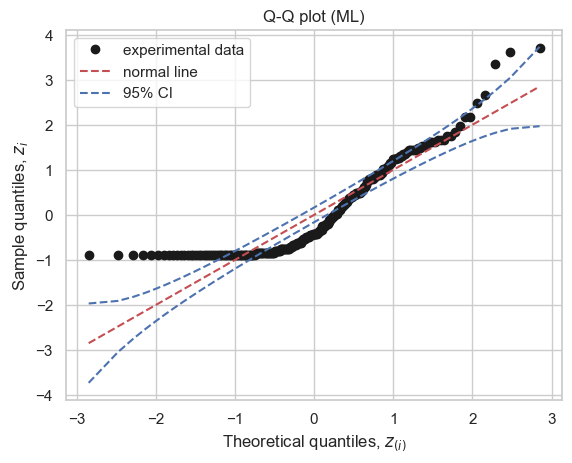

In [61]:
#considering distribution of death time over the whole data
df_patients_q = df_patients[(df_patients["death"]==1)].copy()
y = df_patients_q["death_time"].tolist()
DS_Q_Q_Plot(y)

Estimation method: ML
n = 106, mu = 23.49, sigma = 23.99
Expected number of data outside CI: 5


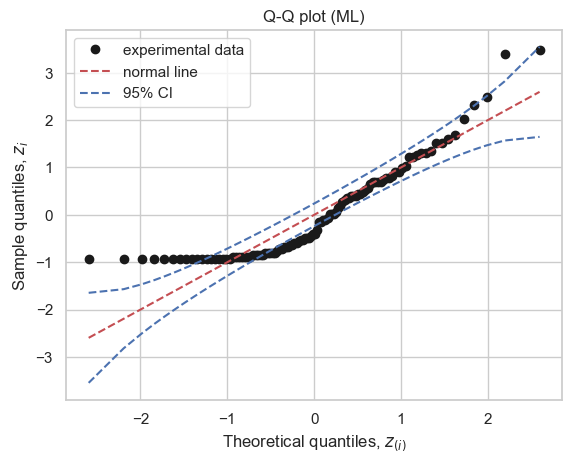

In [62]:
#considering distribution of death time over diabetes
df_patients_q = df_patients[(df_patients["death"]==1) & (df_patients["diabetes"] == 1)].copy()

y = df_patients_q["death_time"].tolist()
DS_Q_Q_Plot(y)

Estimation method: ML
n = 108, mu = 18.34, sigma = 21.2
Expected number of data outside CI: 5


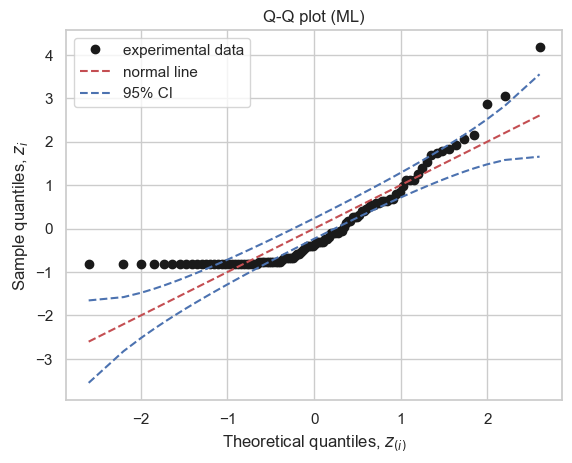

In [63]:
#considering distribution of death time over overweight
df_patients_q = df_patients[(df_patients["death"]==1) & (df_patients["overweight"] == 1)].copy()

y = df_patients_q["death_time"].tolist()
DS_Q_Q_Plot(y)

Estimation method: ML
n = 79, mu = 20.81, sigma = 21.89
Expected number of data outside CI: 4


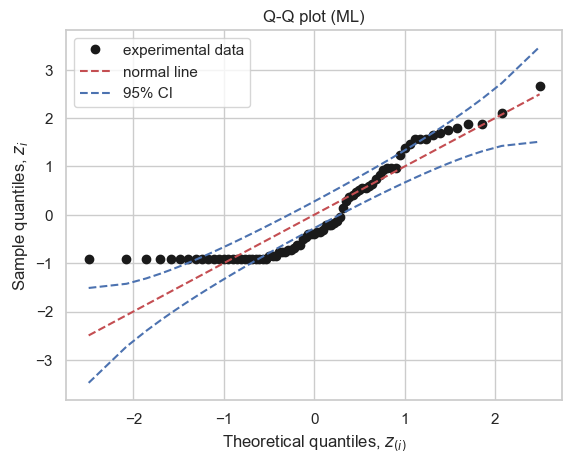

In [64]:
#considering distribution of death time over smoking
df_patients_q = df_patients[(df_patients["death"]==1) & (df_patients["smoking"] == 1)].copy()

y = df_patients_q["death_time"].tolist()
DS_Q_Q_Plot(y)

<span style="color:pink">Explanation: </span>The most of datapoits are all within the (blue) 95% CI of the Q-Q-plot, so data look normal.

---

#### Based on this, the best statistical test that can be utilized in this experiment is 1-sample t-test since the data is almost normal and there is no information about mu and sigma. Based on the data distribution, statistical t-test is implemented to evaluate the hypothesis.For each column it has been considered.A 1- sample T-test can be implemented on the data sets. T-test is the best nominate when there is sparse information about the sample i.e., unknown µ and σ.

In [65]:
#Test the hypotheses 
def DS_1sample_ttest_means(y, popmean=0, alternative = 'two-sided', alpha=0.05):
    """
    *
    Function DS_1sample_ttest_means(y, popmean=0, alternative = 'two-sided', alpha=0.05)
    
       This function performs a 1-sample t-test (Null Hypothesis Significance Test) 
       in the spirit of R, testing 1 average with *unknown* standard deviation.
       The function also evaluates the effect size (Cohen's d).
       
    Requires:          -
     
    Usage:             DS_1sample_ttest_means(y, popmean = mu*, 
                            alternative=['two-sided']/'less'/'greater', 
                            alpha = 0.05)
     
                         alternative = 'two-sided' [default]  H1: mu != mu*
                                       'less'                 H1: mu < mu*
                                       'greater'              H1: mu > mu*
                         alpha:   significance level of test [default: 0.05]
     
    Return:            t, p-value, t.crit.L, t.crit.R  [ + print interpretable output to stdout ]
                       where t.crit.L and t.crit.R are the lower and upper critical values, 
                       t is the test statistic and p-value is the p-value of the test.
                       
    Author:            M.E.F. Apol
    Date:              2022-01-27, rev. 2022_08_26
    Validation:
    """
    
    from scipy.stats import ttest_1samp
    from scipy.stats import t as t_distr
    import numpy as np

    t, p_samp = ttest_1samp(y, popmean)
    print(80*'-')
    print('1-sample t-test for 1 mean:')
    print('     assuming Normal(mu, sigma2) data for dataset')
    y_av = np.mean(y)
    n = len(y)
    df = n - 1
    s2 = np.var(y, ddof=1)
    print('y.av = {:.3g}, mu* = {:.3g}, s2 = {:.3g}, n = {:d}, alpha = {:.3g}'.format(y_av, popmean, s2, n, alpha))
    print('H0: mu  = mu*')
    if alternative == 'two-sided':
        print('H1: mu != mu*')
        p_value = p_samp
        t_crit_L = t_distr.ppf(alpha/2, df)
        t_crit_R = t_distr.ppf(1-alpha/2, df)
    elif alternative == 'less':
        print('H1: mu  < mu*')
        if t <= 0:
            p_value = p_samp/2
        else:
            p_value = 1 - p_samp/2
        t_crit_L = t_distr.ppf(alpha, df)
        t_crit_R = float('inf')
    elif alternative == 'greater':
        print('H1: mu  > mu*')
        if t >= 0:
            p_value = p_samp/2
        else:
            p_value = 1 - p_samp/2
        t_crit_L = float('-inf')
        t_crit_R = t_distr.ppf(1-alpha, df)
    else:
        print('Wrong alternative hypothesis chosen!')
        print(80*'-' + '\n')
        t, p_value, t_crit_L, t_crit_R = np.nan, np.nan, np.nan, np.nan
        return(t, p_value, t_crit_L, t_crit_R)
    # Effect size:
    d_s = t * np.sqrt(1/n)
    print('t = {:.4g}, p-value = {:.4g}, t.crit.L = {:.4g}, t.crit.R = {:.4g}, df = {:.4g}'.format(t, p_value, t_crit_L, t_crit_R, df))
    print('Effect size: d.s = {:.3g}; benchmarks |d.s|: 0.2 = small, 0.5 = medium, 0.8 = large'.format(d_s))
    print(80*'-' + '\n')
    return(t, p_value, t_crit_L, t_crit_R)



### H1: Among those who had done the kideny transplant, Is diabetic people life exptencency less than people who are non-diabetic?

In [66]:
y_diabetes = df_patients[(df_patients["death"] == 1) & (df_patients["diabetes"] == 1)]["death_time"].tolist()
DS_1sample_ttest_means(y_diabetes, popmean=21.58, alternative = 'less', alpha=0.05)

--------------------------------------------------------------------------------
1-sample t-test for 1 mean:
     assuming Normal(mu, sigma2) data for dataset
y.av = 23.5, mu* = 21.6, s2 = 575, n = 106, alpha = 0.05
H0: mu  = mu*
H1: mu  < mu*
t = 0.8201, p-value = 0.793, t.crit.L = -1.659, t.crit.R = inf, df = 105
Effect size: d.s = 0.0797; benchmarks |d.s|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(0.820115504895369, 0.7929959390602865, -1.6594953833914656, inf)

<span style="color:pink">Explanation: </span>Since the p-value = 0.793 > 0.05, the death time is not significantly less than non-diabetic people.
Consequently, we cannot accept hypothesis H1. 

---

### H1: Among those who had done the kideny transplant, Is overweight(high BMI) people life exptencency less than people who are not obese?

In [67]:

y_overweight = df_patients[(df_patients["death"] == 1) & (df_patients["overweight"] == 1)]["death_time"].tolist()
DS_1sample_ttest_means(y_overweight, popmean=21.58, alternative = 'less', alpha=0.05)

--------------------------------------------------------------------------------
1-sample t-test for 1 mean:
     assuming Normal(mu, sigma2) data for dataset
y.av = 18.3, mu* = 21.6, s2 = 450, n = 108, alpha = 0.05
H0: mu  = mu*
H1: mu  < mu*
t = -1.587, p-value = 0.05777, t.crit.L = -1.659, t.crit.R = inf, df = 107
Effect size: d.s = -0.153; benchmarks |d.s|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(-1.5866201102497826, 0.05777480701316954, -1.6592193118671423, inf)

<span style="color:pink">Explanation: </span>Since the p-value = 0.05777 > 0.05, According to the previous consideration in this research, the p-value is almost 0.05 and we cannot reject H1 so easily, so we can mention that overweight has influenced the death time after kidney transplantation.

---

### H1: Among those who had done the kideny transplant, is smokers life exptencency less than people who are not smoking?

In [68]:

y_smoking = df_patients[(df_patients["death"] == 1) & (df_patients["smoking"] == 1)]["death_time"].tolist()
DS_1sample_ttest_means(y_smoking, popmean=21.58, alternative = 'less', alpha=0.05)

--------------------------------------------------------------------------------
1-sample t-test for 1 mean:
     assuming Normal(mu, sigma2) data for dataset
y.av = 20.8, mu* = 21.6, s2 = 479, n = 79, alpha = 0.05
H0: mu  = mu*
H1: mu  < mu*
t = -0.3126, p-value = 0.3777, t.crit.L = -1.665, t.crit.R = inf, df = 78
Effect size: d.s = -0.0352; benchmarks |d.s|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(-0.3125872495927805, 0.37771422847168223, -1.6646246444385244, inf)

<span style="color:pink">Explanation: </span>Since p-value = 0.3777 > 0.05 we reject H1: The death time is not significantly dependent to smoking parameter.

---

### H1: Among those who had done the kideny transplant, does the type of dialysis that paitients used affect the death time or not ?

In [69]:
y_dialysis_type = df_patients[(df_patients["death"] == 1) & (df_patients["dialysis_type"] == 1)]["death_time"].tolist()
DS_1sample_ttest_means(y_dialysis_type, popmean=21.58, alternative = 'less', alpha=0.05)

--------------------------------------------------------------------------------
1-sample t-test for 1 mean:
     assuming Normal(mu, sigma2) data for dataset
y.av = 21.7, mu* = 21.6, s2 = 531, n = 219, alpha = 0.05
H0: mu  = mu*
H1: mu  < mu*
t = 0.08202, p-value = 0.5326, t.crit.L = -1.652, t.crit.R = inf, df = 218
Effect size: d.s = 0.00554; benchmarks |d.s|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(0.08201904273949935, 0.5326465870257808, -1.651873372668681, inf)

<span style="color:pink">Explanation: </span>Since p-value = 0.5326 > 0.05 we reject H1: The death time is not significantly dependent to dialysis type of paitients as an important parameter.

## Part 5: Conclusion

To conclude, the parameters of diebtes, smoking and dialysis types are not considered as a cause of death after people has done the kidney transplantation, on the other hand, high BMI might influence the life expectancy and it's recommended to control it after the surgury.